# Discussion of Lag-Adjusted Spearman Rank Correlation
** Derivation of the lag-adjusted Spearman Rank Correlation Test **

### Motivation
We hope to test the dependence between wastewater injection and seismicity. More specifically, we seek to test if seismicity is associated with wastewater injection in a positive and monotonic way. The Spearman Rank Correlation Test (SRCT) would do exactly this if all assumptions are met.

However, we hypothesize that the effect of injection on seismicity will occur at some lag $\geq$ 0 months. If the lag is > 0 (e.g. if wastewater injection is associated with increased seismicity at least 1 month in the future), then seismicity depends on past water injection. 

In this document, we adjust the SRCT to handle associations at different lags and propose a Spearman Rank Cross-Correlation Test (SRCCT). 

### Spearman's Rank Correlation
Spearman's rank correlation, $r_s$, of two processes, $X$ and $Y$, is defined as follows: 

$$ r_s = 1 - \frac{6D}{N^3-N} $$ 

where $r_s$ is the rank correlation, $N$ is the total number of observations in the sample and $D$ is defined as follows: 

$$ D = \sum{[\text{rank}(X_i) - \text{rank}(Y_i)]^2} $$

Equivalently, we can write $r_s$ in terms of the moments of the ranked data (this is Pearson's correlation coefficient computed on ranked data):

$$ r_s = \frac{\text{cov}(\text{rank}(X),\text{rank}(Y))}{\sigma_{\text{rank}(X)}\sigma_{\text{rank}(Y)}} $$

A statistical test could be defined where the null hypothesis $H_0$ is $r_s \neq 0$. If at least one of the series is exchangeable then under the null hypothesis, all permutations of the data are equally likely to occur and each $r_s$ generated is equally likely. Therefore a p-value could be generated by computing 1 minus the percentile of the original $r_s$ in relation to the distribution of $r_s$ generated by the permutations.  

### Pearson's Cross-Correlation

First, we consider cross-correlation in terms of the "raw" data (i.e. we discuss Pearson's correlation coefficient). 

Computing the cross-correlation for two series at a particular lag is equivalent to computing the correlation between the two series shifted by the appropriate lag. For instance, if we consider the two processes $X_1, X_2, ... , X_n$ and $Y_1, Y_2, ... , Y_n$ and we want to compute the cross correlation at lag = 1, this is equivalent to computing Pearson's correlation for $X_1, X_2, ... , X_{n-1}$ and $Y_2, Y_3, ... , Y_n$. 

The cross-correlation version of Pearson's statistic, $r_p$, will therefore be:

$$ r_p = \frac{\gamma_{X,Y}(\tau)}{\sigma_{X}\sigma_{Y}} $$ 

where

$$ \gamma_{X,Y}(\tau) = \mathrm{E}[(X_t - \mu_X)(Y_{t+\tau} - \mu_Y)] $$

Since, for this test we already assume that at least one of the series is exchangeable, then the two series are jointly exchangeable and thus jointly stationary. It follows then that we can fix $\mu$ and $\sigma$ for both $X$ and $Y$ for any lag $\tau$. Further, we fix the sample size $n$ in computation of the covariance so different lags are appropriately comparable. 

### Spearman's Cross-Correlation

Since Spearman's Rank Correlation coefficient is simply Pearson's correlation on ranked data, it would be reasonable to define the Rank Cross-Correlation as the normal cross-correlation but with ranked data. So, we would have:

$$ r_p = \frac{\gamma_{\text{rank}(X),\text{rank}(Y)}(\tau)}{\sigma_{\text{rank}(X)}\sigma_{\text{rank}(Y)}} $$ 

where

$$ \gamma_{\text{rank}(X),\text{rank}(Y)}(\tau) = \mathrm{E}[(\text{rank}(X)_t - \mu_{\text{rank}(X)})(\text{rank}(Y)_{t+\tau} - \mu_{\text{rank}(Y)})] $$

Like before, we fix $\mu$, $\sigma$, and $n$. Further, it should be noted that ranks are computed *before* taking the lag (i.e. the data is not "re-ranked" after a lag is chosen). 

### Issues and Questions

#### Why does our cross-correlation statistic favor some lags over others?

Below is code that generates a plot which shows that the rank cross-correlation statistic defined above tends to favor lag 0 much more than other lags. 

In [19]:
%%time

import numpy as np

# create two ranked processes of length 450
a = np.arange(1, 451)
b = np.arange(1, 451)
avg = np.mean(a) # mean(a) == mean(b)
var = np.var(a) # var(a) == var(b)

# compute correlations keeping mean, var, n constant
def custom_cor(x, y):
    cov = np.sum((x - avg) * (y - avg)) / 450.
    return cov / var

# compute correlations for every lag
def all_cor(x, y):
    all_lags = [custom_cor(x, y)] # 0th lag
    all_lags.extend(list(map(lambda i: custom_cor(x[:-i], y[i:]), range(1, 450)))) # lags 1-449
    return all_lags

# simulate: for random permutations of a,b which lags have the largest correlation
# the output `lags` is length 450 where the index denotes the lag; it counts the
# number of times where that lag had the largest correlation
lags = np.zeros(450)
for i in range(100000):
    np.random.shuffle(a) # creating pseudo-permutations (for speed)
    sim_cor = all_cor(a, b)
#     lags[np.argmax(sim_cor)] += 1
    largest_lag = np.where(sim_cor == max(sim_cor))[0]
    lags[largest_lag[-1]] += 1

Wall time: 9min 10s


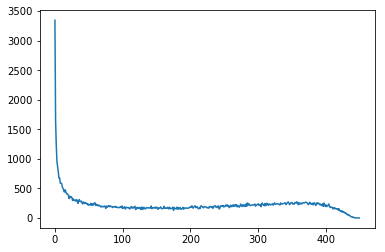

In [21]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# x-axis: lag
# y-axis: frequency
plt.plot(lags)
plt.show()

#### What is the intuition behind how a correlation statistic should perform?

* Take for instance two processes $X = (1, 2, ..., 5)$ and $Y = (1, 2, ..., 5)$. It is clear that any correlation statistic for $X$ and $Y$ should be 1 (i.e. the largest possible correlation statistic). Looking at the cross-correlation for lag 1 is comparing $X = (1, 2, 3, 4)$ and $Y = (2, 3, 4, 5)$. It is clear that at lag 1, X and Y are increasing with each other in a strictly monotonic way. So, the correlation statistic should be 1 in this case as well. 

    - However, for our correlation statistic, this is not the case since we compute the mean, variance, and n for all the data and then fix it. So, under the Spearman cross-correlation, the lag 1 correlation is less than the lag 0 correlation. 


* Following from the above example with lag 1, say we were looking at ranks. Why should we not re-rank $Y$ so that $Y = (1, 2, 3, 4)$? Not re-ranking preserves the ranks of the observations relative to the observations that fall off (due to truncating the series from introducing the lag). But it is not clear why we should consider the data that was truncated. 

    - In this case, since we are not considering the observations that were dropped off due to the lag, we should also then vary the mean, variance, and n. Below is a simulation that does just this.

#### Re-ranking after choosing a lag

The one problem with re-ranking is that extremely high lags will tend to have very high correlation since the size of $n$ decreases as the lag increases. Take for example the case of two lists of length 10. Then, for lag 8, the effective sample size drops to 2. Additionally, since the lists are re-ranked, the only possible arrangements are list1 = [1, 2]; list2 = [1, 2] or list1 = [1, 2]; list2 = [2, 1]. So, under random permutations, lag 8 will have the maximum correlation 50% of the time. Below is code that shows this.

In [17]:
%%time

import numpy as np
from scipy.stats import rankdata

# create two ranked processes of length 200
a = np.arange(1, 51)
b = np.arange(1, 51)

# get correlation (do not fix mean, variance, n)
def corr(x, y):
    cov = np.sum((x - np.mean(x)) * (y - np.mean(y))) / (len(x)-1)
    sdx = np.std(x, ddof=1)
    sdy = np.std(y, ddof=1)
    return cov / (sdx*sdy)

# compute correlations for every lag (do not fix mean, variance, n)
def all_cor2(x, y, maxlag):
    all_lags = [corr(x, y)] # 0th lag
    all_lags.extend(list(map(lambda i: corr(rankdata(x[:-i]), rankdata(y[i:])), range(1, maxlag))))
    return all_lags

# simulate: for random permutations of a,b which lags have the largest correlation
# the output `lags` is length 199 where the index denotes the lag; it counts the
# number of times where that lag had the largest correlation
lags2 = np.zeros(49)
for i in range(5000):
    np.random.shuffle(a) # creating pseudo-permutations (for speed)
    sim_cor = all_cor2(a, b, 49)
    lags2[np.argmax(sim_cor)] += 1

Wall time: 1min 9s


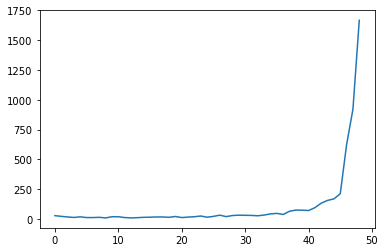

In [18]:
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# x-axis: lag
# y-axis: frequency
plt.plot(lags2)
plt.show()

However, what if we simply do not compute correlation at large lags since we know that the sample size becomes too small in those cases. Results are shown below.

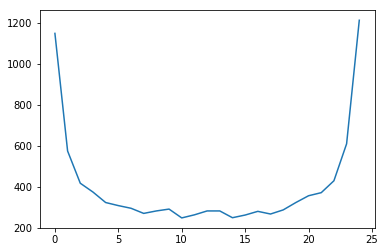

Wall time: 1min 20s


In [14]:
%%time

# create two ranked processes of length 400
a = np.arange(1, 401)
b = np.arange(1, 401)

# compute correlations for every lag (do not fix mean, variance, n)
def all_cor2(x, y, maxlag):
    all_lags = [corr(x, y)] # 0th lag
    all_lags.extend(list(map(lambda i: corr(rankdata(x[:-i]), rankdata(y[i:])), range(1, maxlag))))
    return all_lags

# simulate: for random permutations of a,b which lags have the largest correlation
# the output `lags` is length 450 where the index denotes the lag; it counts the
# number of times where that lag had the largest correlation
lags2 = np.zeros(25)
for i in range(10000):
    np.random.shuffle(a) # creating pseudo-permutations (for speed)
    sim_cor = all_cor2(a, b, 25)
    lags2[np.argmax(sim_cor)] += 1
    
# x-axis: lag
# y-axis: frequency
plt.plot(lags2)
plt.show()